# NLP Portfolio exercise

This final task has rather open instructions: analyze text message data using Natural Language Processing techniques and libraries.

We are using the dataset consisting of SMS messages.

Kudos for data go to:
* Tao Chen and Min-Yen Kan (2013). Creating a Live, Public Short Message Service Corpus: The NUS SMS Corpus. Language Resources and Evaluation, 47(2)(2013), pages 299-355. URL: https://link.springer.com/article/10.1007%2Fs10579-012-9197-9

We will use:
* pandas, matplotlib, seaborn for EDA
* ntlk, re for text processing
* spaCy for vectors
* sklearn for ML modelling

### Peeking into and cleaning data 

In [3]:
import pandas as pd

data = pd.read_csv("clean_nus_sms.csv")
print(data.head())

   Unnamed: 0     id                                            Message  \
0           0  10120                              Bugis oso near wat...   
1           1  10121  Go until jurong point, crazy.. Available only ...   
2           2  10122     I dunno until when... Lets go learn pilates...   
3           3  10123  Den only weekdays got special price... Haiz......   
4           4  10124                             Meet after lunch la...   

  length country    Date  
0     21      SG  2003/4  
1    111      SG  2003/4  
2     46      SG  2003/4  
3    140      SG  2003/4  
4     22      SG  2003/4  


In [4]:
print(data.columns)
print(data.shape)
print(data.dtypes)
data = data.dropna()
print(data.isna().sum())

Index(['Unnamed: 0', 'id', 'Message', 'length', 'country', 'Date'], dtype='object')
(48598, 6)
Unnamed: 0     int64
id             int64
Message       object
length        object
country       object
Date          object
dtype: object
Unnamed: 0    0
id            0
Message       0
length        0
country       0
Date          0
dtype: int64


In [5]:
data = data.drop("Unnamed: 0", axis=1)
print(data.columns)

Index(['id', 'Message', 'length', 'country', 'Date'], dtype='object')


In [6]:
data.columns = [col.lower() for col in data.columns]
print(data.columns)

Index(['id', 'message', 'length', 'country', 'date'], dtype='object')


* **id**: Unique identifier for each message.
* **message**: The message contents.
* **length**: Total number of characters in the message.
* **country**: Country the sender is from.
* **date**: Month and Year a message was sent.

### Tidying up "country"

In [9]:
print(data.country.unique())

['SG' 'MY' 'India' 'Pakistan' 'United States' 'Canada' 'unknown' 'Serbia'
 'United Kingdom' 'France' 'Singapore' 'China' 'Malaysia' 'Sri Lanka'
 'Spain' 'Bangladesh' 'Philippines' 'Macedonia' 'Romania' 'Kenya'
 'Slovenia' 'New Zealand' 'Nigeria' 'Ghana' 'Indonesia' 'Nepal' 'Morocco'
 'USA' 'Lebanon' 'india' 'Trinidad and Tobago' 'INDIA' 'srilanka'
 'jamaica' 'Hungary' 'Australia' 'Italia' 'BARBADOS' 'Turkey' 'UK']


In [10]:
country_replacements = {
    "srilanka": "Sri Lanka",
    "india": "India",
    "INDIA": "India",
    "SG": "Singapore",
    "MY": "Malaysia",
    "UK": "United Kingdom",
    "jamaica": "Jamaica",
    "BARBADOS": "Barbados",
    "USA": "United States"
}

data["country"] = data["country"].replace(country_replacements, regex=True)
print(data.country.unique())

['Singapore' 'Malaysia' 'India' 'Pakistan' 'United States' 'Canada'
 'unknown' 'Serbia' 'United Kingdom' 'France' 'China' 'Sri Lanka' 'Spain'
 'Bangladesh' 'Philippines' 'Macedonia' 'Romania' 'Kenya' 'Slovenia'
 'New Zealand' 'Nigeria' 'Ghana' 'Indonesia' 'Nepal' 'Morocco' 'Lebanon'
 'Trinidad and Tobago' 'Jamaica' 'Hungary' 'Australia' 'Italia' 'Barbados'
 'Turkey']


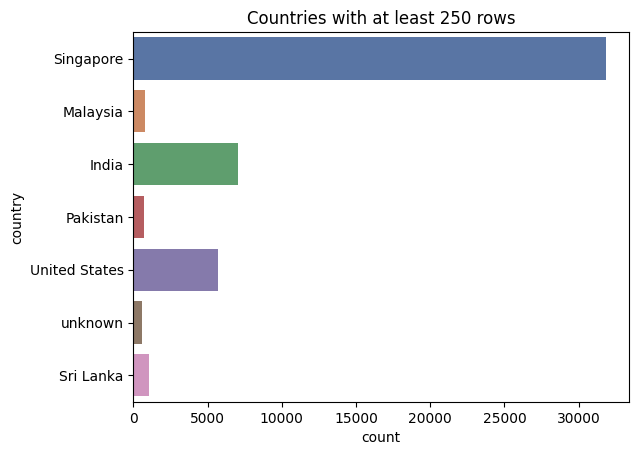

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

country_counts = data["country"].value_counts()
filtered_countries = data[data["country"].isin(country_counts[country_counts > 250].index)]

sns.countplot(y="country", data=filtered_countries, hue="country", palette="deep")
plt.title("Countries with at least 250 rows")
plt.show()

### Tidying up "length"

In [13]:
data['length'] = pd.to_numeric(data['length'], errors='coerce')
data = data.dropna(subset=['length'])
data['length'] = data['length'].astype(int)
data.dtypes

id          int64
message    object
length      int32
country    object
date       object
dtype: object

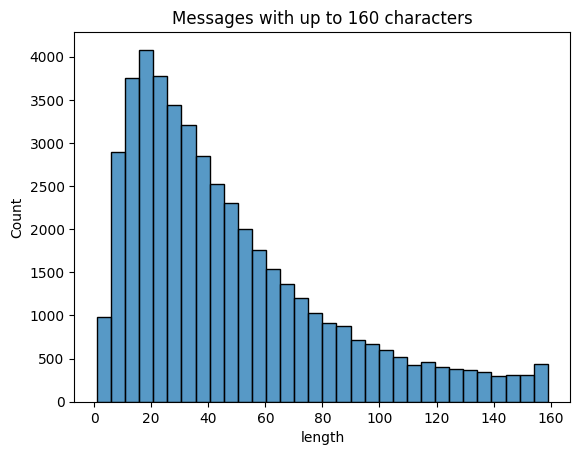

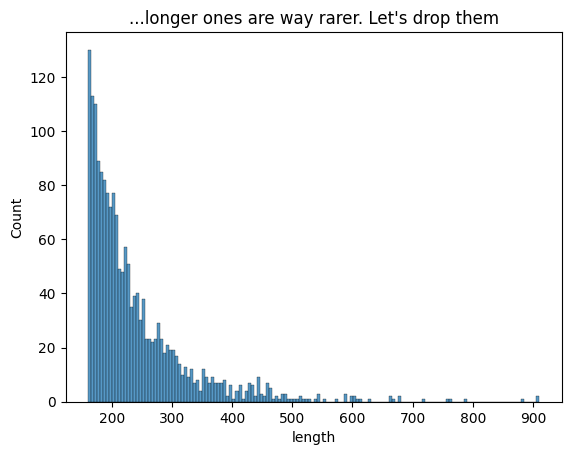

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(x="length", data=data[data.length < 160], binwidth=5)
plt.title("Messages with up to 160 characters")
plt.show()
sns.histplot(x="length", data=data[data.length > 160], binwidth=5)
plt.title("...longer ones are way rarer. Let's drop them")
plt.show()

In [15]:
data = data.drop(data[data['length'] > 160].index)
data.shape

(46808, 5)

### Checking dates

In [17]:
print(data.date.unique())

['2003/4' '2010/11' '2010/12' '2011/1' '2011/2' '2011/3' '2011/4' '2011/5'
 '2011/6' '2011/8' '2011/9' '2011/11' '2011/12' '2012/2' '2012/3' '2012/4'
 '2012/5' '2012/6' '2012/7' '2012/8' '2012/10' '2013/5' '2014/9' '2014/11'
 '2014/12' '2015/2' '2015/3']


### Tidying up messages themselves

In [19]:
print(data.message[564])

m thinking of u... So wat r u doing?


#### Are they in English only?

In [21]:
print(data.message[data.country == "Slovenia"].head())

45005    Cao baby...sleeping? When you wake up call me,...
45006                    Tnx. Ill be there <#> pas <#> :-)
45007    Dude check out when we start tomorow if you ar...
45008                          Whats wrong? Are you angry?
45009            I love you too my baby, ill always do! <3
Name: message, dtype: object


#### Let's turn them into tokens and lemmas and strip them of stopwords and other noise

In [23]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tag import pos_tag
from nltk import FreqDist, ngrams
from nltk.corpus import stopwords, wordnet

import string

In [24]:
print(data.message[1234])
print(word_tokenize(data.message[1234]))

Leona birthday on sun we meeting on fri for dinner u free ?
['Leona', 'birthday', 'on', 'sun', 'we', 'meeting', 'on', 'fri', 'for', 'dinner', 'u', 'free', '?']


In [25]:
data["message"] = data["message"].astype(str)
data["tokens"] = data["message"].str.lower().apply(word_tokenize)

In [26]:
data.head(3)
data.dtypes

id          int64
message    object
length      int32
country    object
date       object
tokens     object
dtype: object

In [27]:
stops = stopwords.words('english')
more_stops = ["u", "r", "..", "...", "la", "e", "wat", "go", "got", "'s", "ok", "n't", "ur", "okay",
    "'m", "le", "hey", "going", "come", "oh",
    "one", "see", "get", "wan", "like", "still", "want", "yeah", "hi",
    "ya", "eh", "call", "lor", "na", "dun", "back", "today", "take", "day", "ah", "also", "n", "k",
    "ask", "4", "tmr", "'ll", "free", "say", "already", "sure", "hee", "tell", "im",
    "really", "let", "dont", "coming", "soon", "right", "make", "much", "yes",
    "p", "b", "next", "den", "well", "dunno", "da",
    "find", "night", "yup", "de", "thing", "way", "lo", "yet",
    "msg", "long", "try", "min", "last", "sm", "lunch", "hmm", "maybe",
    "ohh", "abt", "pls", "sch", "please", "reply", "week",
    "said", "cant", "may", "end", "c", "co", "yo", "lot", "ca", "``",
    "omg", "hai", "btw", "pls", "eh", "ya", "u", "dunno", "nvm", "ü", "lah", "....",
    "''", "``", "2", "4", "1", "3", "5", 'need', 'thanks', 'sm', 'guy', "'re", 'ok.', 'co', "nan", "know"]
all_stops = stops + more_stops + list(string.punctuation)
drop_stops = lambda x: [token for token in x if token not in all_stops]
data["tokens"] = data["tokens"].apply(drop_stops)

In [28]:
print(data.tokens[1234])
print(data.tokens[1])
data.head(3)

['leona', 'birthday', 'sun', 'meeting', 'fri', 'dinner']
['jurong', 'point', 'crazy', 'available', 'bugis', 'great', 'world', 'buffet', 'cine', 'amore']


,id,message,length,country,date,tokens
0,10120,Bugis oso near wat...,21,Singapore,2003/4,"[bugis, oso, near]"
1,10121,"Go until jurong point, crazy.. Available only ...",111,Singapore,2003/4,"[jurong, point, crazy, available, bugis, great..."
2,10122,I dunno until when... Lets go learn pilates...,46,Singapore,2003/4,"[lets, learn, pilates]"


In [29]:
lemmatizer = WordNetLemmatizer()
data["lemmas"] = data["tokens"].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])

data = data[data["lemmas"].apply(lambda x: len(x) > 0)]

In [30]:
print(data.lemmas[1])
data.head(3)

['jurong', 'point', 'crazy', 'available', 'bugis', 'great', 'world', 'buffet', 'cine', 'amore']


,id,message,length,country,date,tokens,lemmas
0,10120,Bugis oso near wat...,21,Singapore,2003/4,"[bugis, oso, near]","[bugis, oso, near]"
1,10121,"Go until jurong point, crazy.. Available only ...",111,Singapore,2003/4,"[jurong, point, crazy, available, bugis, great...","[jurong, point, crazy, available, bugis, great..."
2,10122,I dunno until when... Lets go learn pilates...,46,Singapore,2003/4,"[lets, learn, pilates]","[let, learn, pilate]"


In [31]:
flat_lemmas = data['lemmas'].explode()

frequency = FreqDist(flat_lemmas)
print(frequency.most_common(50))

[('haha', 4868), ('lol', 2780), ('time', 1801), ('hahaha', 1271), ('home', 1201), ('think', 1157), ('good', 1138), ('later', 1127), ('meet', 1063), ('sorry', 1042), ('leh', 735), ('love', 728), ('eat', 685), ('late', 685), ('first', 679), ('dear', 632), ('liao', 574), ('buy', 572), ('happy', 532), ('send', 530), ('reach', 527), ('dinner', 525), ('decimal', 511), ('help', 498), ('wait', 476), ('work', 476), ('nice', 467), ('bus', 453), ('morning', 453), ('meeting', 441), ('bring', 409), ('sleep', 406), ('u', 397), ('hope', 381), ('house', 381), ('email', 379), ('check', 377), ('sm', 366), ('give', 365), ('new', 363), ('class', 359), ('tonight', 358), ('friend', 352), ('early', 320), ('co', 311), ('ha', 307), ('watch', 303), ('v', 302), ('anyway', 300), ('place', 299)]


#### What are most common words?

In [33]:
flat_US = data['lemmas'][data.country == "United States"].explode()
flat_india = data['lemmas'][data.country == "India"].explode()

freq_US = FreqDist(flat_US)

freq_india = FreqDist(flat_india)

print(f"Most common in US messages: {freq_US.most_common(50)}\n")
print(f"Most common in Indian messages: {freq_india.most_common(50)}")

Most common in US messages: [('lol', 272), ('time', 168), ('love', 167), ('sorry', 143), ('good', 140), ('haha', 134), ('think', 122), ('text', 95), ('great', 91), ('gon', 90), ("'ve", 90), ('=p', 90), ('home', 86), ('xp', 86), ('tomorrow', 85), ('would', 79), ('alright', 79), ('work', 76), ('around', 75), ('later', 68), ('could', 67), ('hope', 66), ('send', 64), ('stuff', 57), ('new', 57), ('phone', 57), ('name', 55), ('guy', 55), ('cool', 53), ('probably', 52), ('aight', 52), ('mom', 52), ('tonight', 51), ('nice', 50), ("'d", 50), ('meet', 49), ('people', 49), ('something', 48), ('talk', 47), ('fine', 47), ('number', 47), ('class', 47), ('better', 47), ('even', 46), ('late', 46), ('post', 46), ('thank', 45), ('dude', 45), ('done', 45), ('=d', 45)]

Most common in Indian messages: [('good', 198), ('dear', 152), ('gud', 133), ('time', 126), ('happy', 125), ('sorry', 121), ('bhai', 119), ('life', 101), ('send', 98), ('love', 97), ('home', 96), ('kya', 93), ('nai', 85), ('tomorrow', 84),

In [34]:
data.shape

(44454, 7)

#### Let's visualize in wordclouds

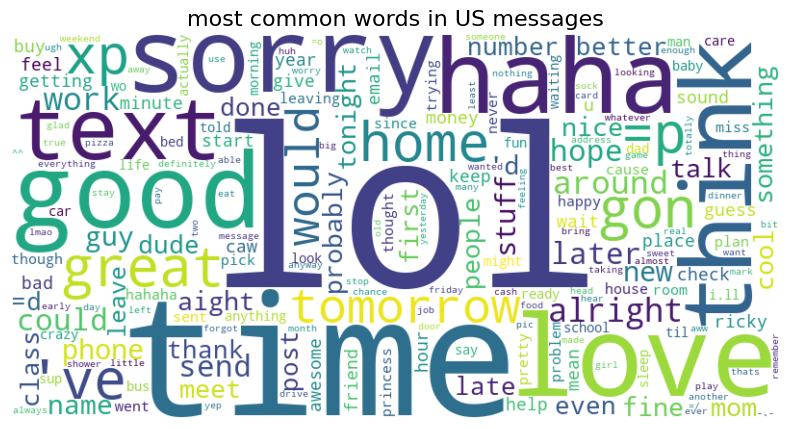

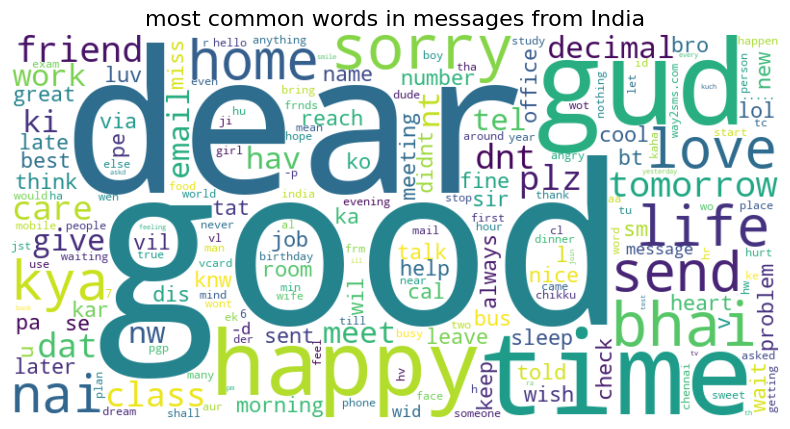

In [36]:
from wordcloud import WordCloud

def make_wordcloud(dist, title):
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(dist)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()

make_wordcloud(freq_US, "most common words in US messages")
make_wordcloud(freq_india, "most common words in messages from India")

## Analysis idea
I will vectorize the messages, build a model, and train it on the data to predict the message's origin.

Let's reduce it to treat the risk of data imbalance
We'll be **predicting whether the message came from US or India**

We'll try following:
* 1/ turning messages into vectors
* 2/ applying decision trees / random forest / naive bayes on them

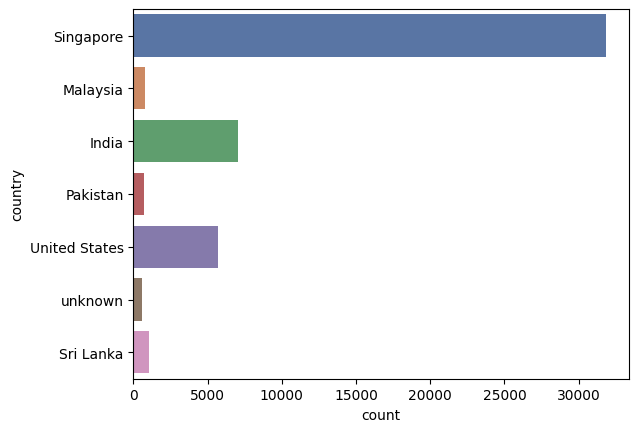

In [38]:
sns.countplot(y="country", data=filtered_countries, hue="country", palette="deep")
plt.show()

### Adding vectors with spaCy

In [40]:
import spacy
nlp = spacy.load('en_core_web_md', disable=["tagger", "parser", "ner"])

In [41]:
import warnings
warnings.filterwarnings("ignore", message=r"\[W108\]", category=UserWarning)

sample = data.sample(100)
sample["vectors"] = sample["message"].apply(lambda x: nlp(x).vector)

In [42]:
sample["vectors"].head

<bound method NDFrame.head of 34491    [1.461869, 1.2774022, -2.0788, -0.44168973, 0....
38405    [-1.1010985, 0.7477854, -2.41425, -1.0507245, ...
34295    [-1.8000635, -1.7005749, 5.943685, 1.9397532, ...
26197    [0.87713504, 3.3088944, -4.3880553, -1.4061834...
4721     [0.82172, 0.74537534, -2.8898368, -0.96135926,...
                               ...                        
8991     [-0.30886388, 1.4251378, -2.6452792, -0.732528...
23077    [-0.6952786, 0.10424771, -2.880321, -0.6907982...
3988     [-0.48715585, 0.3901759, -0.9986911, -0.583421...
45437    [-0.29289258, 7.42145, -4.266925, -1.7295123, ...
43387    [1.1733248, 1.3489059, -3.9622815, -1.8902591,...
Name: vectors, Length: 100, dtype: object>

In [43]:
data_small = data[data.country.isin(["United States", "India"])].copy()
data_small.shape

(11433, 7)

In [44]:
import warnings
warnings.filterwarnings("ignore", message="\[W108\]")

data_small["vectors"] = data_small["message"].apply(lambda x: nlp(x).vector)

In [45]:
data_small.head()

,id,message,length,country,date,tokens,lemmas,vectors
9808,2,Studying?,9,India,2010/11,[studying],[studying],"[-2.32237, 2.4294, -3.849465, -0.579255, -0.11..."
9809,3,Vch photo,9,India,2010/11,"[vch, photo]","[vch, photo]","[0.58115, -0.205815, -2.43995, -1.443, 1.5009,..."
9810,4,K:-)ya i hav to finish,22,India,2010/11,"[hav, finish]","[hav, finish]","[-1.1754, 4.16452, -2.03648, -3.6407304, -3.99..."
9811,6,One senioq akka,15,India,2010/11,"[senioq, akka]","[senioq, akka]","[-1.10136, -0.6691, 1.7301432, 0.36350998, 0.7..."
9813,8,She vil mistake me only cha.dnt talk to me also,47,India,2010/11,"[vil, mistake, cha.dnt, talk]","[vil, mistake, cha.dnt, talk]","[0.32705402, 3.6619296, -3.129175, -1.7810199,..."


In [46]:
import numpy as np

data_small['vector_avg'] = data_small['vectors'].apply(
    lambda x: np.mean(x)
).astype(float)
data_small['country_label'] = data_small['country'].apply(lambda x: 0 if x == 'United States' else 1)

In [47]:
data_small.head()

,id,message,length,country,date,tokens,lemmas,vectors,vector_avg,country_label
9808,2,Studying?,9,India,2010/11,[studying],[studying],"[-2.32237, 2.4294, -3.849465, -0.579255, -0.11...",-0.235789,1
9809,3,Vch photo,9,India,2010/11,"[vch, photo]","[vch, photo]","[0.58115, -0.205815, -2.43995, -1.443, 1.5009,...",0.018892,1
9810,4,K:-)ya i hav to finish,22,India,2010/11,"[hav, finish]","[hav, finish]","[-1.1754, 4.16452, -2.03648, -3.6407304, -3.99...",-0.179939,1
9811,6,One senioq akka,15,India,2010/11,"[senioq, akka]","[senioq, akka]","[-1.10136, -0.6691, 1.7301432, 0.36350998, 0.7...",-0.073851,1
9813,8,She vil mistake me only cha.dnt talk to me also,47,India,2010/11,"[vil, mistake, cha.dnt, talk]","[vil, mistake, cha.dnt, talk]","[0.32705402, 3.6619296, -3.129175, -1.7810199,...",-0.302797,1


In [48]:
data_vect = data_small[["country_label", "vector_avg"]]
data_vect.head()

,country_label,vector_avg
9808,1,-0.235789
9809,1,0.018892
9810,1,-0.179939
9811,1,-0.073851
9813,1,-0.302797


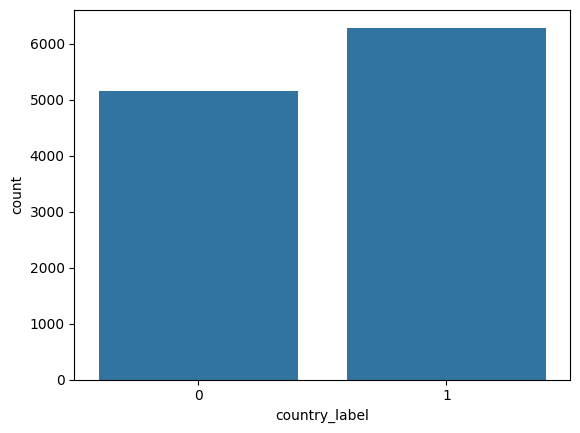

In [49]:
sns.countplot(x="country_label", data=data_vect)
plt.show()

We have a sampled data with codes for US and India and averaged value of message vectors.

### Let's grow some trees

In [51]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

df = data_vect.copy()

X = df.drop("country_label", axis=1)
y = df["country_label"]

In [52]:
def make_tree(X, y, df):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
    
    tree = DecisionTreeClassifier(random_state = 42, max_depth=8, criterion="gini")
    tree.fit(X_train, y_train)

    predictions = tree.predict(X_test)

    print(f"Accuracy score: {accuracy_score(y_test, predictions)}")
    print(f"F1 score: {f1_score(y_test, predictions)}")

In [53]:
make_tree(X, y, df)

Accuracy score: 0.5443812855268911
F1 score: 0.5746938775510205


In [54]:
def make_forest(X, y, df):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
    
    forest = RandomForestClassifier(max_depth=5, min_samples_leaf=1, min_samples_split=20, n_estimators=100)
    forest.fit(X_train, y_train)

    predictions = forest.predict(X_test)

    print(f"Accuracy score: {accuracy_score(y_test, predictions)}")
    print(f"F1 score: {f1_score(y_test, predictions)}")

In [55]:
make_forest(X, y, df)

Accuracy score: 0.5513773502404897
F1 score: 0.6233480176211453


That's not fabulous score.

### Playing with other vectors and Naïve Bayes that can read them

In [57]:
import re
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text.lower()

data_small['cleaned_message'] = data_small['message'].apply(clean_text)

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

vectorizer = TfidfVectorizer()
data_small['tfidf'] = list(vectorizer.fit_transform(data_small['cleaned_message']).toarray())

data_small.head()

,id,message,length,country,date,tokens,lemmas,vectors,vector_avg,country_label,cleaned_message,tfidf
9808,2,Studying?,9,India,2010/11,[studying],[studying],"[-2.32237, 2.4294, -3.849465, -0.579255, -0.11...",-0.235789,1,studying,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9809,3,Vch photo,9,India,2010/11,"[vch, photo]","[vch, photo]","[0.58115, -0.205815, -2.43995, -1.443, 1.5009,...",0.018892,1,vch photo,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9810,4,K:-)ya i hav to finish,22,India,2010/11,"[hav, finish]","[hav, finish]","[-1.1754, 4.16452, -2.03648, -3.6407304, -3.99...",-0.179939,1,kya i hav to finish,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9811,6,One senioq akka,15,India,2010/11,"[senioq, akka]","[senioq, akka]","[-1.10136, -0.6691, 1.7301432, 0.36350998, 0.7...",-0.073851,1,one senioq akka,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9813,8,She vil mistake me only cha.dnt talk to me also,47,India,2010/11,"[vil, mistake, cha.dnt, talk]","[vil, mistake, cha.dnt, talk]","[0.32705402, 3.6619296, -3.129175, -1.7810199,...",-0.302797,1,she vil mistake me only chadnt talk to me also,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [59]:
X = data_small["cleaned_message"]
X_train, X_test, y_train, y_test = train_test_split(X, data_small["country_label"], test_size=0.2, random_state=42)

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [60]:
from sklearn.naive_bayes import MultinomialNB

def get_naive(X_train, X_test, y_train, y_test):
    naive = MultinomialNB()
    naive.fit(X_train, y_train)

    y_pred = naive.predict(X_test)

    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"F1: {f1_score(y_test, y_pred)}")

In [61]:
get_naive(X_train, X_test, y_train, y_test)

Accuracy: 0.8268473983384347
F1: 0.838893409275834


In [62]:
X = data_small["lemmas"].apply(lambda lemmas: " ".join(lemmas))
y = data_small["country_label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

get_naive(X_train, X_test, y_train, y_test)

Accuracy: 0.8032356799300393
F1: 0.8283752860411899


## Conclusion

* We peeked into, visualized and normalized into dataframe.

* We cleaned / tidied / preprocessed (tokenized, lemmatized) textual data.

* We used several methods to label and **vectorize** them: spaCy NLP objects, **TFIDF**.

* We applied decision trees, random forest and **naïve Bayes** models; fit them on split data and predicted test slice.

* We climbed, after some fine-tuning, to score about **0.8399**.
